# Download Datasets

In [1]:
import urllib.request
import os #用於確認檔案

if not os.path.exists('data'):
    os.makedirs('data')

url = "https://biostat.app.vumc.org/wiki/pub/Main/DataSets/titanic3.xls"
filepath = "data/titanic3.xls"
if not os.path.isfile(filepath):
    result = urllib.request.urlretrieve(url, filepath)
    print('downloaded:', result)

# Data preprocessing
需要xlrd讀取Excel文件  
`pip install xlrd`  
使用pandas的read_excel讀取titanic.xls至dataframe


In [2]:
import numpy
import pandas as pd
all_df = pd.read_excel(filepath)
all_df[:2]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"


# Filter datasets

In [3]:
cols = ['survived', 'name', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
all_df = all_df[cols]
all_df[:2]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked
0,1,"Allen, Miss. Elisabeth Walton",1,female,29.0000,0,0,211.3375,S
1,1,"Allison, Master. Hudson Trevor",1,male,0.9167,1,2,151.5500,S


# pandas dataframe:drop function
`drop(labels = None, axis = 0, index = None, columns = None, inplace = False)`  
 - label就是要刪除的行列名稱 用列表給定
 - axis默認=0 刪除行 因此刪除columns時axis需= 1
 - columns指定要刪除的column
 - inplace = False 默認該刪除操作不改變圓數據 而是return一個執行刪除後的新dataframe
 - inplace = True 則會直接在原數據上做刪除 刪除後無法返回

Reference: [Python中pandas dataframe删除一行或一列：drop函数](https://blog.csdn.net/songyunli1111/article/details/79306639)

In [4]:
df = all_df.drop(['name'], axis = 1)

找出含有null的欄位

In [5]:
all_df.isnull().sum()

survived      0
name          0
pclass        0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
dtype: int64

fillna:使用指定的方法填充NA/NaN值  
`df.fillna(0)` 將NA/NaN填充為0  
詳細看:[pandas fillna使用](https://blog.csdn.net/conving/article/details/120205513)

In [6]:
# 计算平均年龄和平均票价
age_mean = df['age'].mean()
fare_mean = df['fare'].mean()

# 填充缺失值
df['age'] = df['age'].fillna(age_mean)
df['fare'] = df['fare'].fillna(fare_mean)
df['sex'] = df['sex'].map({'female': 0, 'male': 1}).astype(int, errors='ignore')

x_OneHot_df = pd.get_dummies(data = df, columns=["embarked"])
x_OneHot_df[:2]

,survived,pclass,sex,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
0,1,1,0,29.0000,0,0,211.3375,False,False,True
1,1,1,1,0.9167,1,2,151.5500,False,False,True


# Dataframe傳換為array

In [7]:
ndarray = x_OneHot_df.values
print(ndarray.shape) # 1309筆 10個欄位
print(ndarray[:2])

(1309, 10)
[[1 1 0 29.0 0 0 211.3375 False False True]
 [1 1 1 0.9167 1 2 151.55 False False True]]


In [8]:
Label = ndarray[:, 0]
Features = ndarray[:, 1:]

print(Label[:2])
print(Features[:2])

[1 1]
[[1 0 29.0 0 0 211.3375 False False True]
 [1 1 0.9167 1 2 151.55 False False True]]


# Standardize

In [9]:
from sklearn import preprocessing
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaledFeatures = minmax_scale.fit_transform(Features)
scaledFeatures[:2]

array([[0.        , 0.        , 0.36116884, 0.        , 0.        ,
        0.41250333, 0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.00939458, 0.125     , 0.22222222,
        0.2958059 , 0.        , 0.        , 1.        ]])

# Split data

In [10]:
msk = numpy.random.rand(len(all_df)) < 0.8
train_df = all_df[msk] # 80%
test_df = all_df[~msk] # 20%

print('total:', len(all_df), 'train:', len(train_df), 'test:', len(test_df))

total: 1309 train: 1022 test: 287


# Build PreprocessingData function 

In [11]:
def PreprocessingData(raw_df):
    df = raw_df.drop(['name'], axis = 1)
    age_mean = df['age'].mean()
    df['age'] = df['age'].fillna(age_mean)
    fare_mean = df['fare'].mean()
    df['fare'] = df['fare'].fillna(fare_mean)
    df['sex'] = df['sex'].map({'female': 0, 'male': 1}).astype(int)
    x_OneHot_df = pd.get_dummies(data = df, columns=["embarked"])

    ndarray = x_OneHot_df.values
    Features = ndarray[:, 1:]
    Label = ndarray[:, 0]

    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaledFeatures = minmax_scale.fit_transform(Features)

    return scaledFeatures, Label

# Model Training Error
在model training時會遇到:`ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).`  
是因為Label被解釋為不支持的對象類型 因為在Tensorflow中Label通常應該是int或float  
所以需要`train_Label = train_Label.astype(int)` or `train_Label = train_Label.astype(float)`  

In [12]:
train_Features, train_Label = PreprocessingData(train_df)
test_Featurers, test_Label = PreprocessingData(test_df)

train_Label = train_Label.astype(int)

In [13]:
train_Features[:2]

array([[0.        , 0.        , 0.36116884, 0.        , 0.        ,
        0.41250333, 0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.00939458, 0.125     , 0.22222222,
        0.2958059 , 0.        , 0.        , 1.        ]])

In [14]:
train_Label[:2]

array([1, 1])

# Build Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(
    units = 40,
    input_dim = 9,
    kernel_initializer = 'uniform',
    activation = 'relu'
))
model.add(Dense(
    units = 30,
    kernel_initializer = 'uniform',
    activation = 'relu'
))
model.add(Dense(
    units = 1,
    kernel_initializer = 'uniform',
    activation = 'sigmoid'
))

d:\Program\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Training Model

In [16]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

train_history = model.fit(
    x = train_Features,
    y = train_Label,
    validation_split = 0.1,
    epochs = 30,
    batch_size = 30,
    verbose = 2
)

Epoch 1/30
31/31 - 2s - 61ms/step - accuracy: 0.5930 - loss: 0.6885 - val_accuracy: 0.8252 - val_loss: 0.6566
Epoch 2/30
31/31 - 0s - 3ms/step - accuracy: 0.5963 - loss: 0.6602 - val_accuracy: 0.8252 - val_loss: 0.5429
Epoch 3/30
31/31 - 0s - 3ms/step - accuracy: 0.6583 - loss: 0.6073 - val_accuracy: 0.8155 - val_loss: 0.4672
Epoch 4/30
31/31 - 0s - 6ms/step - accuracy: 0.7704 - loss: 0.5593 - val_accuracy: 0.8058 - val_loss: 0.4204
Epoch 5/30
31/31 - 0s - 3ms/step - accuracy: 0.7802 - loss: 0.5261 - val_accuracy: 0.7961 - val_loss: 0.4388
Epoch 6/30
31/31 - 0s - 3ms/step - accuracy: 0.7693 - loss: 0.5083 - val_accuracy: 0.7961 - val_loss: 0.4183
Epoch 7/30
31/31 - 0s - 2ms/step - accuracy: 0.7693 - loss: 0.5084 - val_accuracy: 0.8058 - val_loss: 0.4065
Epoch 8/30
31/31 - 0s - 3ms/step - accuracy: 0.7715 - loss: 0.4917 - val_accuracy: 0.7961 - val_loss: 0.4062
Epoch 9/30
31/31 - 0s - 3ms/step - accuracy: 0.7748 - loss: 0.4864 - val_accuracy: 0.7961 - val_loss: 0.4180
Epoch 10/30
31/31 

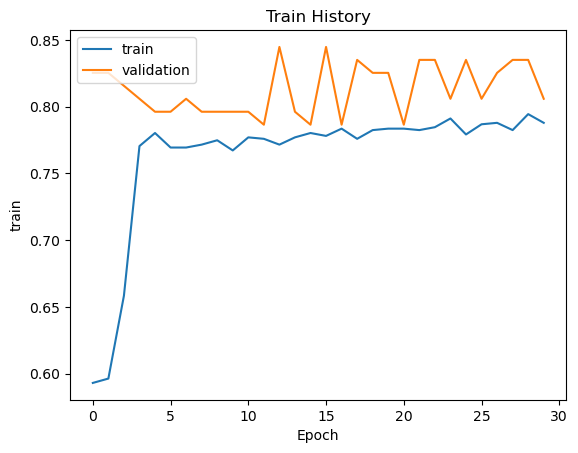

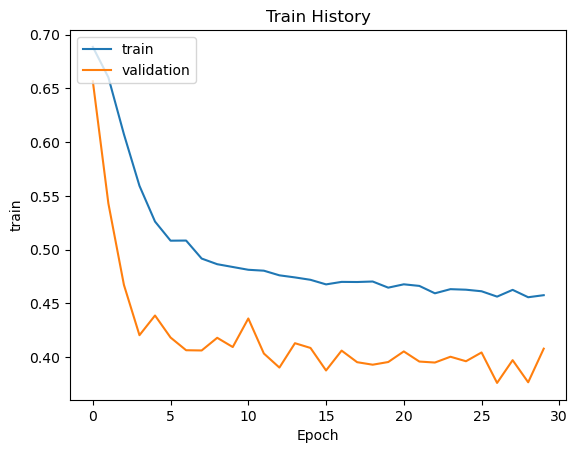

In [17]:
import matplotlib.pyplot as plt
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel('train')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.show()

show_train_history(train_history, 'accuracy', 'val_accuracy')
show_train_history(train_history, 'loss', 'val_loss')

# Evaluate Model Accuracy

Error:`ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).`  
跟上面處理方式一樣`test_Label = test_Label.astype(int)`  

In [18]:
test_Label = test_Label.astype(int)
scores = model.evaluate(
    x = test_Featurers,
    y = test_Label
)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8203 - loss: 0.4019 


In [19]:
scores[1]

0.8118466734886169

In [20]:
Jack = pd.Series([0, 'Jack', 3, 'male', 23, 1, 0, 5.0000, 'S'])
Rose = pd.Series([1, 'Rose', 1, 'female', 20, 1, 0, 100.0000, 'S'])

In [21]:
JR_df = pd.DataFrame([list(Jack), list(Rose)],
                     columns=['survived', 'name', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked'])

In [23]:
all_df = pd.concat([all_df, JR_df])
all_df[-2:]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked
0,0,Jack,3,male,23.0,1,0,5.0,S
1,1,Rose,1,female,20.0,1,0,100.0,S


In [24]:
all_Features, Label = PreprocessingData(all_df)

In [26]:
all_probability = model.predict(all_Features)
all_probability[:10]

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step


array([[0.96159893],
       [0.60030675],
       [0.95909107],
       [0.38704768],
       [0.955321  ],
       [0.28411865],
       [0.90940905],
       [0.34049538],
       [0.90433973],
       [0.24797599]], dtype=float32)

In [32]:
pd = all_df
pd.insert(len(all_df.columns),
          'probability', all_probability)
pd[-2:]

ValueError: cannot insert probability, already exists